In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


Text(0, 0.5, 'Sale Price')

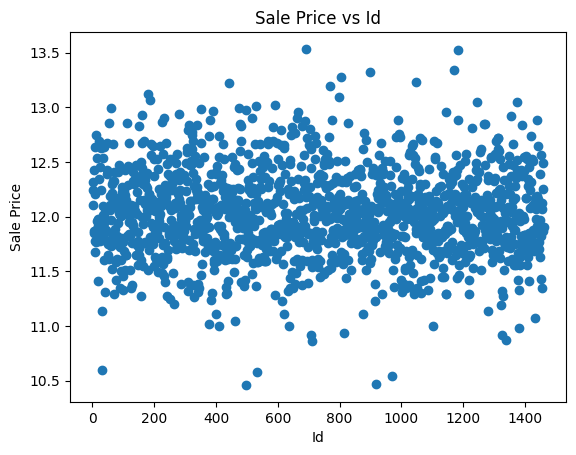

In [2]:
train = pd.read_csv("/kaggle/input/home-data-for-ml-course/train.csv")
test = pd.read_csv("/kaggle/input/home-data-for-ml-course/test.csv")

# Save Id for submission
train_ids = train["Id"]
sale_price = train["SalePrice"]
test_ids = test["Id"]

x_train = train.drop(["Id", "SalePrice"], axis =1 )
# log (1+sale_price) to stabilize
y_train = np.log1p(sale_price)
x_test = test.drop(["Id"], axis = 1)

plt.scatter(train_ids, y_train, )
plt.title("Sale Price vs Id")
plt.xlabel("Id")
plt.ylabel("Sale Price")

In [3]:
numeric_features = x_train.select_dtypes(include=["int", "float"]).columns
categorical_features = x_train.select_dtypes(include=["object"]).columns

#print(numeric_features, numeric_features.shape, categorical_features, categorical_features.shape)
# -----------------------
# Preprocessing Pipelines
# -----------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [4]:
# -----------------------
# Linear Regression Model
# -----------------------
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

lasso_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Lasso(alpha=0.001, random_state=42))  # alpha controla força da regularização
])

ridge_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Ridge(alpha=0.001, random_state=42))  # alpha controla força da regularização
])

elastic_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42))  # alpha controla força da regularização
])


X_tr, X_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# -----------------------
# Cross-validation to check performance
# -----------------------
cv_results = cross_validate(
    elastic_model,
    x_train,
    y_train, 
    cv=5,
    scoring="neg_root_mean_squared_error",
    return_train_score=True
)

print("Average RMSE Treino:", -cv_results["train_score"].mean())
print("Average RMSE Validação:", -cv_results["test_score"].mean())
# -----------------------
# Train on full data
# -----------------------
elastic_model.fit(x_train, y_train)

# -----------------------
# Predict on test set
# -----------------------
preds_log = elastic_model.predict(test)
preds = np.expm1(preds_log)  # reverse log1p

Average RMSE Treino: 0.10818942104427295
Average RMSE Validação: 0.13686982073389706


(292,)


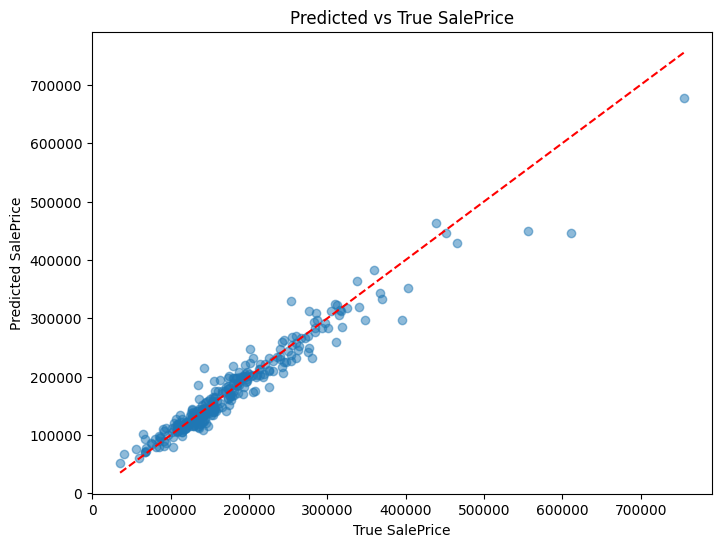

RMSE Treino (log scale): 0.11263817025675713
Validation RMSE (log scale): 0.11025882172236647


In [5]:
pred_tr_log = elastic_model.predict(X_tr)

preds_val_log = elastic_model.predict(X_val)
preds_val = np.expm1(preds_val_log)
y_val_final = np.expm1(y_val)

print(y_val_final.shape)
plt.figure(figsize=(8,6))
plt.scatter(y_val_final, preds_val, alpha=0.5)
plt.plot([y_val_final.min(), y_val_final.max()], [y_val_final.min(), y_val_final.max()], 'r--')  # linha y=x
plt.xlabel("True SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Predicted vs True SalePrice")
plt.show()

rmse_tr = np.sqrt(mean_squared_error(y_tr, pred_tr_log))
rmse_val = np.sqrt(mean_squared_error(y_val, preds_val_log))
print("RMSE Treino (log scale):", rmse_tr)
print("Validation RMSE (log scale):", rmse_val)
#plt.plot([y_val_final.min(), y_val_final.max()], [y_val_final.min(), y_val_final.max()])  #

In [6]:
submission = pd.DataFrame({
    "Id": test_ids,
    "SalePrice": preds
})
submission.to_csv("submission.csv", index=False)
print("Submission file created successfully!")


Submission file created successfully!
